# Forward model

In [30]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')

from jax.config import config

config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=10,10

from src.utils import spherical_volume, volume_fourier, volume_comp, mip_z, mip_x
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
import jax

### Create volume

Text(0.5, 1.0, 'Volume_comp MIP')

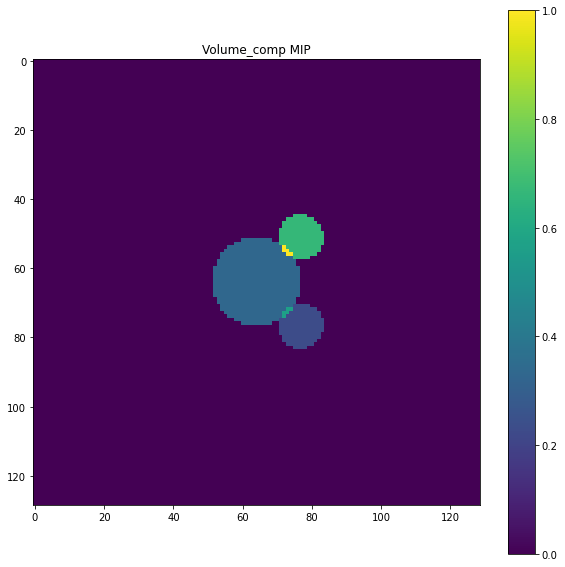

In [32]:
nx = 129
shape = np.array([129,129,129])
dimensions = np.array([1,1,1])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [0.1, 0.1, 0], [0.1, -0.1, 0]])
radii = np.array([0.1, 0.05, 0.05])
intensities = np.array([10,7,20])

v = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False, sigma = 0.01))
mip_z(v)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

### Project

0.8312580585479736


Text(0.5, 1.0, 'Vol FFT slice')

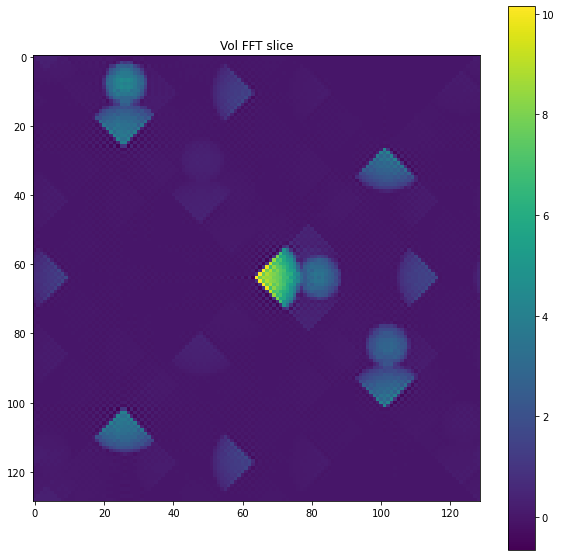

In [33]:
angles = jnp.array([0, 0, jnp.pi/4])
#shifts = jnp.array([-20,-30])*pixel_size
shifts = jnp.array([0,0])

start = time.time()
v_slice = project_spatial(v, angles, pixel_size, shifts, "tri", pfac=2)
print(time.time()-start)

plt.imshow(v_slice); plt.colorbar()
plt.title('Vol FFT slice')

## Nearest neighbour interpolation

1.1186809539794922


Text(0.5, 1.0, 'NN')

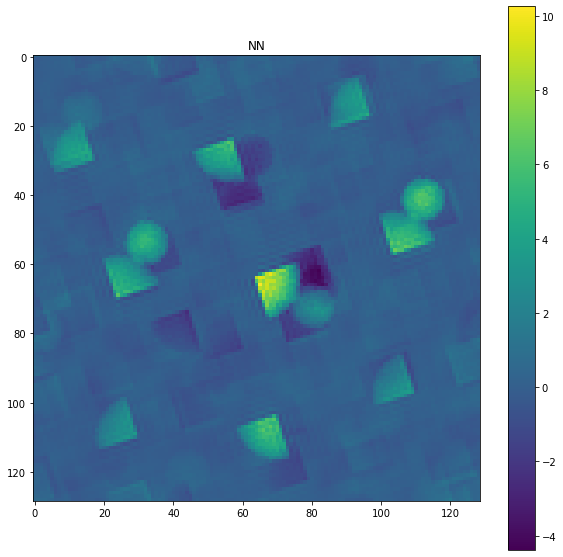

In [34]:
#angles = jnp.array([0,np.pi/2,jnp.pi/1000])
angles = jnp.array([0,0,jnp.pi/10])

start = time.time()
slice_nn = project_spatial(v, angles, pixel_size, shifts, "nn", pfac = 2)
print(time.time()-start)


plt.imshow(slice_nn); plt.colorbar()
plt.title("NN")

# Point source

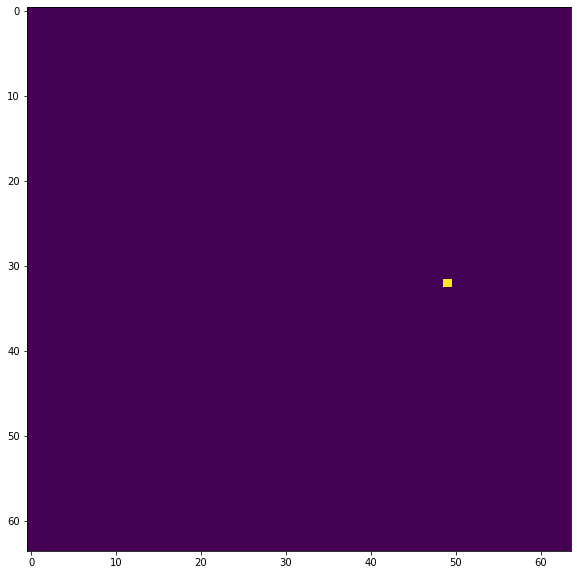

In [35]:
nx = 64
dx = 0.2

v = np.zeros([nx,nx,nx])
v[32,49,32] = 1

mip_z(v)

1.2029709815979004


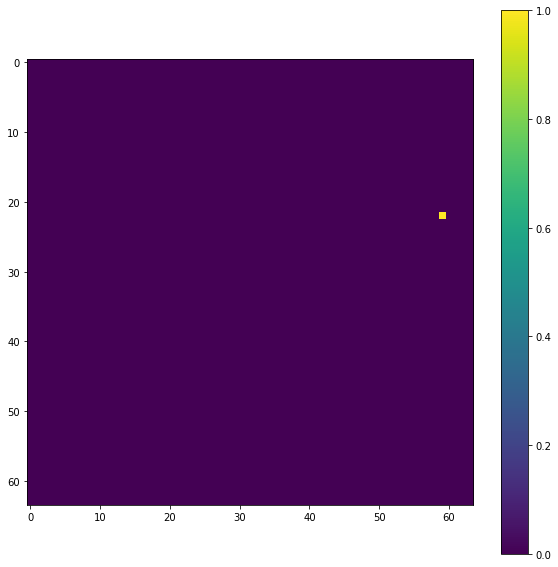

In [36]:
angles = jnp.array([0, 0, 0])

start = time.time()
proj = project_spatial(v, angles, pixel_size, [-10,10], "tri")
print(time.time()-start)

plt.imshow(proj); plt.colorbar()


In [37]:
print(np.max(proj))
print(np.min(proj))

1.0
-4.093774670673025e-14
